Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


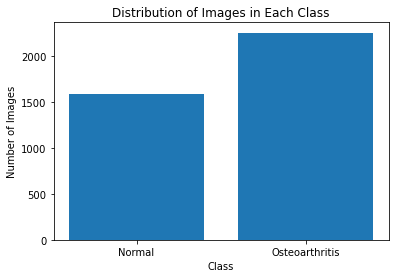

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-24 10:19:13.837832: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 10:19:14.031041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 10:19:14.031076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 10:19:14.064151: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 10:19:14.132090: I tensorflow/core/platform/cpu_feature_guar

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


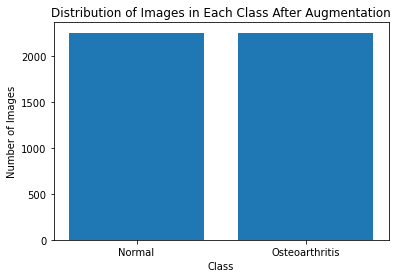

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 2000)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 2000)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 2000 + [1] * 2000  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 2240
X_test size: 1200
X_validation size: 560


In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score

# CNN+Dense

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Preprocess data
X_train = np.array(X_train) / 255.0  # Scale pixel values to [0, 1]
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 22s 302ms/step - loss: 0.7955 - accuracy: 0.5179 - val_loss: 0.6809 - val_accuracy: 0.5929
Epoch 2/50
70/70 [==============================] - 21s 305ms/step - loss: 0.6859 - accuracy: 0.5375 - val_loss: 0.6806 - val_accuracy: 0.5143
Epoch 3/50
70/70 [==============================] - 21s 305ms/step - loss: 0.6795 - accuracy: 0.5540 - val_loss: 0.6756 - val_accuracy: 0.5482
Epoch 4/50
70/70 [==============================] - 22s 308ms/step - loss: 0.6654 - accuracy: 0.5804 - val_loss: 0.6589 - val_accuracy: 0.5607
Epoch 5/50
70/70 [==============================] - 22s 314ms/step - loss: 0.6533 - accuracy: 0.5848 - val_loss: 0.6466 - val_accuracy: 0.5946
Epoch 6/50
70/70 [==============================] - 22s 314ms/step - loss: 0.6370 - accuracy: 0.6094 - val_loss: 0.6409 - val_accuracy: 0.5946
Epoch 7/50
70/70 [==============================] - 22s 314ms/step - loss: 0.6126 - accuracy: 0.6353 - val_loss: 0.6550 - val_accuracy: 0.6250

38/38 [==============================] - 3s 73ms/step


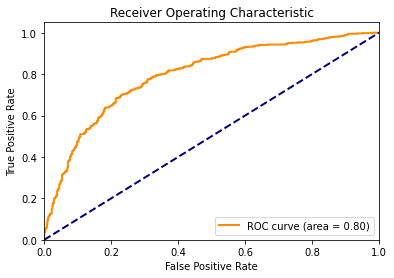

18/18 [==============================] - 1s 71ms/step - loss: 0.5730 - accuracy: 0.7321
Validation Loss: 0.5730206370353699
Validation Accuracy: 0.7321428656578064
Test Loss: 0.6006569347816749
Inference Time (seconds): 3.081716537475586
Test Accuracy: 0.7166666666666667
Confusion Matrix:
 [[396 226]
 [114 464]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.64      0.70       622
           1       0.67      0.80      0.73       578

    accuracy                           0.72      1200
   macro avg       0.72      0.72      0.72      1200
weighted avg       0.73      0.72      0.72      1200

ROC AUC Score: 0.7958366247955586
Metrics saved successfully


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 22s 318ms/step - loss: 0.3209 - accuracy: 0.8638 - val_loss: 0.5863 - val_accuracy: 0.7482
Epoch 2/100
70/70 [==============================] - 22s 317ms/step - loss: 0.2537 - accuracy: 0.8884 - val_loss: 0.5817 - val_accuracy: 0.7643
Epoch 3/100
70/70 [==============================] - 22s 313ms/step - loss: 0.2117 - accuracy: 0.9138 - val_loss: 0.6439 - val_accuracy: 0.7589
Epoch 4/100
70/70 [==============================] - 22s 314ms/step - loss: 0.1662 - accuracy: 0.9348 - val_loss: 0.6106 - val_accuracy: 0.7768
Epoch 5/100
70/70 [==============================] - 22s 311ms/step - loss: 0.1297 - accuracy: 0.9545 - val_loss: 0.7060 - val_accuracy: 0.7571
Epoch 6/100
70/70 [==============================] - 22s 314ms/step - loss: 0.0946 - accuracy: 0.9647 - val_loss: 0.7621 - val_accuracy: 0.7821
Epoch 7/100
70/70 [==============================] - 22s 313ms/step - loss: 0.0702 - accuracy: 0.9772 - val_loss: 0.8315 - val_accuracy:

38/38 [==============================] - 3s 73ms/step


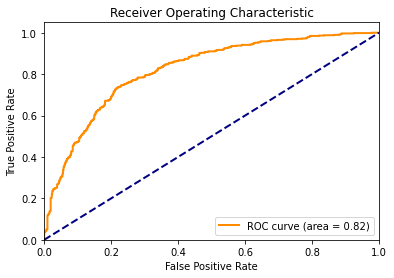

18/18 [==============================] - 1s 71ms/step - loss: 0.5817 - accuracy: 0.7643
Validation Loss: 0.5817040205001831
Validation Accuracy: 0.7642857432365417
Test Loss: 0.6471633597383647
Inference Time (seconds): 3.111107587814331
Test Accuracy: 0.7483333333333333
Confusion Matrix:
 [[452 170]
 [132 446]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       622
           1       0.72      0.77      0.75       578

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200

ROC AUC Score: 0.8197326405500729
Metrics saved successfully


In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 22s 314ms/step - loss: 0.2088 - accuracy: 0.9156 - val_loss: 0.6453 - val_accuracy: 0.7732
Epoch 2/150
70/70 [==============================] - 22s 312ms/step - loss: 0.1679 - accuracy: 0.9348 - val_loss: 0.6865 - val_accuracy: 0.7625
Epoch 3/150
70/70 [==============================] - 22s 314ms/step - loss: 0.1220 - accuracy: 0.9607 - val_loss: 0.7337 - val_accuracy: 0.7804
Epoch 4/150
70/70 [==============================] - 22s 312ms/step - loss: 0.1195 - accuracy: 0.9585 - val_loss: 0.7036 - val_accuracy: 0.7679
Epoch 5/150
70/70 [==============================] - 22s 314ms/step - loss: 0.0807 - accuracy: 0.9781 - val_loss: 0.8609 - val_accuracy: 0.7786
Epoch 6/150
70/70 [==============================] - 22s 314ms/step - loss: 0.0647 - accuracy: 0.9853 - val_loss: 0.8663 - val_accuracy: 0.7696
Training Time: 131.94240760803223 seconds


38/38 [==============================] - 3s 73ms/step


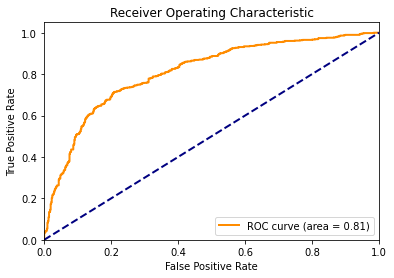

18/18 [==============================] - 1s 71ms/step - loss: 0.6453 - accuracy: 0.7732
Validation Loss: 0.6452958583831787
Validation Accuracy: 0.7732142806053162
Test Loss: 0.7165138341184879
Inference Time (seconds): 3.026463270187378
Test Accuracy: 0.7433333333333333
Confusion Matrix:
 [[500 122]
 [186 392]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76       622
           1       0.76      0.68      0.72       578

    accuracy                           0.74      1200
   macro avg       0.75      0.74      0.74      1200
weighted avg       0.75      0.74      0.74      1200

ROC AUC Score: 0.8092908243304888
Metrics saved successfully


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 22s 315ms/step - loss: 0.1600 - accuracy: 0.9371 - val_loss: 0.6038 - val_accuracy: 0.7750
Epoch 2/200
70/70 [==============================] - 22s 314ms/step - loss: 0.1295 - accuracy: 0.9518 - val_loss: 0.6543 - val_accuracy: 0.7911
Epoch 3/200
70/70 [==============================] - 22s 314ms/step - loss: 0.1280 - accuracy: 0.9589 - val_loss: 0.6692 - val_accuracy: 0.7875
Epoch 4/200
70/70 [==============================] - 22s 314ms/step - loss: 0.0798 - accuracy: 0.9737 - val_loss: 0.7585 - val_accuracy: 0.7804
Epoch 5/200
70/70 [==============================] - 22s 312ms/step - loss: 0.0613 - accuracy: 0.9826 - val_loss: 0.7492 - val_accuracy: 0.7911
Epoch 6/200
70/70 [==============================] - 22s 314ms/step - loss: 0.0548 - accuracy: 0.9826 - val_loss: 0.9044 - val_accuracy: 0.7679
Training Time: 132.19795989990234 seconds


38/38 [==============================] - 3s 73ms/step


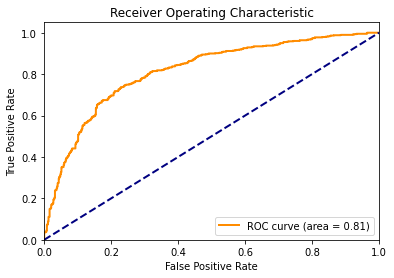

18/18 [==============================] - 1s 71ms/step - loss: 0.6038 - accuracy: 0.7750
Validation Loss: 0.6037544012069702
Validation Accuracy: 0.7749999761581421
Test Loss: 0.8056307245640174
Inference Time (seconds): 3.011035203933716
Test Accuracy: 0.7508333333333334
Confusion Matrix:
 [[520 102]
 [197 381]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78       622
           1       0.79      0.66      0.72       578

    accuracy                           0.75      1200
   macro avg       0.76      0.75      0.75      1200
weighted avg       0.76      0.75      0.75      1200

ROC AUC Score: 0.8125034768967168
Metrics saved successfully


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
metrics={
    'Combination':'CNN+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# CNN+Dropout+Dense

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 35s 497ms/step - loss: 0.8258 - accuracy: 0.5121 - val_loss: 0.6873 - val_accuracy: 0.5821
Epoch 2/50
70/70 [==============================] - 35s 494ms/step - loss: 0.6827 - accuracy: 0.5429 - val_loss: 0.6792 - val_accuracy: 0.5214
Epoch 3/50
70/70 [==============================] - 34s 493ms/step - loss: 0.6768 - accuracy: 0.5643 - val_loss: 0.6757 - val_accuracy: 0.5857
Epoch 4/50
70/70 [==============================] - 35s 497ms/step - loss: 0.6684 - accuracy: 0.5750 - val_loss: 0.6647 - val_accuracy: 0.5893
Epoch 5/50
70/70 [==============================] - 34s 493ms/step - loss: 0.6575 - accuracy: 0.5848 - val_loss: 0.6599 - val_accuracy: 0.5946
Epoch 6/50
70/70 [==============================] - 34s 493ms/step - loss: 0.6552 - accuracy: 0.5915 - val_loss: 0.6537 - val_accuracy: 0.6107
Epoch 7/50
70/70 [==============================] - 34s 493ms/step - loss: 0.6391 - accuracy: 0.5924 - val_loss: 0.6854 - val_accuracy: 0.5786

38/38 [==============================] - 3s 78ms/step


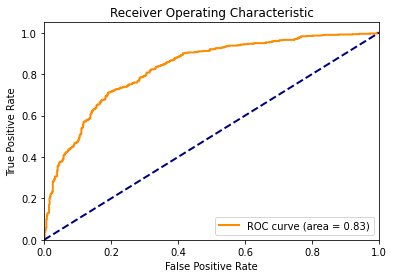

18/18 [==============================] - 1s 78ms/step - loss: 0.5035 - accuracy: 0.7804
Validation Loss: 0.5034863352775574
Validation Accuracy: 0.7803571224212646
Test Loss: 0.5616711226418089
Inference Time (seconds): 3.2232255935668945
Test Accuracy: 0.745
Confusion Matrix:
 [[439 183]
 [123 455]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74       622
           1       0.71      0.79      0.75       578

    accuracy                           0.74      1200
   macro avg       0.75      0.75      0.74      1200
weighted avg       0.75      0.74      0.74      1200

ROC AUC Score: 0.8288351561543852
Metrics saved successfully


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 35s 494ms/step - loss: 0.3016 - accuracy: 0.8679 - val_loss: 0.5717 - val_accuracy: 0.7643
Epoch 2/100
70/70 [==============================] - 34s 493ms/step - loss: 0.2697 - accuracy: 0.8879 - val_loss: 0.5201 - val_accuracy: 0.7821
Epoch 3/100
70/70 [==============================] - 34s 492ms/step - loss: 0.2393 - accuracy: 0.8955 - val_loss: 0.5639 - val_accuracy: 0.7875
Epoch 4/100
70/70 [==============================] - 34s 491ms/step - loss: 0.2123 - accuracy: 0.9089 - val_loss: 0.6279 - val_accuracy: 0.7768
Epoch 5/100
70/70 [==============================] - 34s 492ms/step - loss: 0.2051 - accuracy: 0.9156 - val_loss: 0.6874 - val_accuracy: 0.7714
Epoch 6/100
70/70 [==============================] - 35s 494ms/step - loss: 0.1888 - accuracy: 0.9183 - val_loss: 0.7353 - val_accuracy: 0.7607
Epoch 7/100
70/70 [==============================] - 34s 492ms/step - loss: 0.1770 - accuracy: 0.9268 - val_loss: 0.6185 - val_accuracy:

38/38 [==============================] - 3s 78ms/step


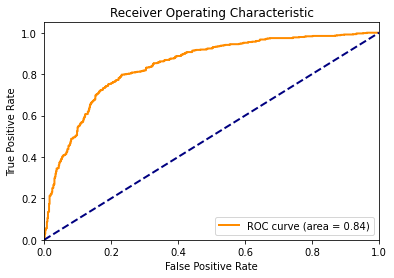

18/18 [==============================] - 1s 77ms/step - loss: 0.5201 - accuracy: 0.7821
Validation Loss: 0.5200541615486145
Validation Accuracy: 0.7821428775787354
Test Loss: 0.5873851600991238
Inference Time (seconds): 3.22011399269104
Test Accuracy: 0.7766666666666666
Confusion Matrix:
 [[469 153]
 [115 463]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.78       622
           1       0.75      0.80      0.78       578

    accuracy                           0.78      1200
   macro avg       0.78      0.78      0.78      1200
weighted avg       0.78      0.78      0.78      1200

ROC AUC Score: 0.8436397823740807
Metrics saved successfully


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [19]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 35s 494ms/step - loss: 0.2226 - accuracy: 0.9027 - val_loss: 0.6297 - val_accuracy: 0.7429
Epoch 2/150
70/70 [==============================] - 34s 492ms/step - loss: 0.2249 - accuracy: 0.9067 - val_loss: 0.5658 - val_accuracy: 0.7786
Epoch 3/150
70/70 [==============================] - 35s 493ms/step - loss: 0.2027 - accuracy: 0.9107 - val_loss: 0.5747 - val_accuracy: 0.8018
Epoch 4/150
70/70 [==============================] - 34s 493ms/step - loss: 0.1813 - accuracy: 0.9254 - val_loss: 0.6750 - val_accuracy: 0.7893
Epoch 5/150
70/70 [==============================] - 34s 491ms/step - loss: 0.1699 - accuracy: 0.9339 - val_loss: 0.6926 - val_accuracy: 0.7875
Epoch 6/150
70/70 [==============================] - 35s 494ms/step - loss: 0.1438 - accuracy: 0.9451 - val_loss: 0.6624 - val_accuracy: 0.8018
Epoch 7/150
70/70 [==============================] - 35s 493ms/step - loss: 0.1631 - accuracy: 0.9371 - val_loss: 0.6716 - val_accuracy:

38/38 [==============================] - 3s 78ms/step


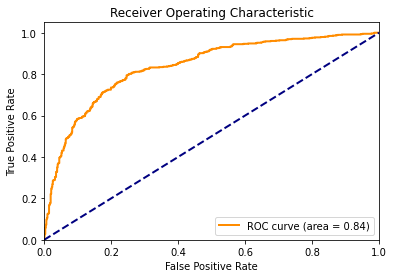

18/18 [==============================] - 1s 77ms/step - loss: 0.5658 - accuracy: 0.7786
Validation Loss: 0.5658490061759949
Validation Accuracy: 0.7785714268684387
Test Loss: 0.6476302399098107
Inference Time (seconds): 3.204591989517212
Test Accuracy: 0.77
Confusion Matrix:
 [[511 111]
 [165 413]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       622
           1       0.79      0.71      0.75       578

    accuracy                           0.77      1200
   macro avg       0.77      0.77      0.77      1200
weighted avg       0.77      0.77      0.77      1200

ROC AUC Score: 0.8366651275603867
Metrics saved successfully


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [21]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 35s 495ms/step - loss: 0.1979 - accuracy: 0.9187 - val_loss: 0.6509 - val_accuracy: 0.7643
Epoch 2/200
70/70 [==============================] - 34s 493ms/step - loss: 0.1761 - accuracy: 0.9286 - val_loss: 0.6345 - val_accuracy: 0.7839
Epoch 3/200
70/70 [==============================] - 34s 492ms/step - loss: 0.1632 - accuracy: 0.9353 - val_loss: 0.6057 - val_accuracy: 0.8089
Epoch 4/200
70/70 [==============================] - 34s 492ms/step - loss: 0.1555 - accuracy: 0.9371 - val_loss: 0.6429 - val_accuracy: 0.7786
Epoch 5/200
70/70 [==============================] - 34s 492ms/step - loss: 0.1384 - accuracy: 0.9429 - val_loss: 0.6616 - val_accuracy: 0.8018
Epoch 6/200
70/70 [==============================] - 34s 493ms/step - loss: 0.1270 - accuracy: 0.9509 - val_loss: 0.6960 - val_accuracy: 0.7857
Epoch 7/200
70/70 [==============================] - 35s 494ms/step - loss: 0.1135 - accuracy: 0.9612 - val_loss: 0.6696 - val_accuracy:

38/38 [==============================] - 3s 78ms/step


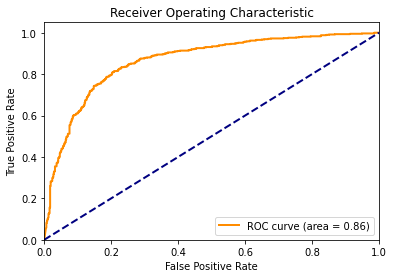

18/18 [==============================] - 1s 76ms/step - loss: 0.6057 - accuracy: 0.8089
Validation Loss: 0.605732798576355
Validation Accuracy: 0.8089285492897034
Test Loss: 0.6436003151824685
Inference Time (seconds): 3.201951742172241
Test Accuracy: 0.8
Confusion Matrix:
 [[484 138]
 [102 476]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       622
           1       0.78      0.82      0.80       578

    accuracy                           0.80      1200
   macro avg       0.80      0.80      0.80      1200
weighted avg       0.80      0.80      0.80      1200

ROC AUC Score: 0.8643871204619544
Metrics saved successfully


In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GlobbalAveragePooling+Dense

In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D

#Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and additional metrics
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 26, 26, 128)      

In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 19s 266ms/step - loss: 0.6950 - accuracy: 0.4996 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 18s 263ms/step - loss: 0.6933 - accuracy: 0.5080 - val_loss: 0.6929 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 18s 262ms/step - loss: 0.6923 - accuracy: 0.5022 - val_loss: 0.6920 - val_accuracy: 0.4875
Epoch 4/50
70/70 [==============================] - 18s 262ms/step - loss: 0.6917 - accuracy: 0.5214 - val_loss: 0.6900 - val_accuracy: 0.5464
Epoch 5/50
70/70 [==============================] - 18s 262ms/step - loss: 0.6913 - accuracy: 0.5259 - val_loss: 0.6895 - val_accuracy: 0.5536
Epoch 6/50
70/70 [==============================] - 18s 262ms/step - loss: 0.6927 - accuracy: 0.5165 - val_loss: 0.6904 - val_accuracy: 0.5518
Epoch 7/50
70/70 [==============================] - 18s 263ms/step - loss: 0.6914 - accuracy: 0.5161 - val_loss: 0.6898 - val_accuracy: 0.5482

38/38 [==============================] - 3s 70ms/step


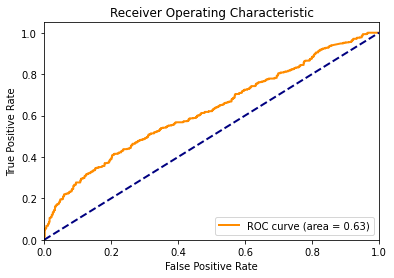

18/18 [==============================] - 1s 68ms/step - loss: 0.6562 - accuracy: 0.5929
Validation Loss: 0.6562302112579346
Validation Accuracy: 0.5928571224212646
Test Loss: 0.6551249486026675
Inference Time (seconds): 2.9005789756774902
Test Accuracy: 0.5991666666666666
Confusion Matrix:
 [[462 160]
 [321 257]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.74      0.66       622
           1       0.62      0.44      0.52       578

    accuracy                           0.60      1200
   macro avg       0.60      0.59      0.59      1200
weighted avg       0.60      0.60      0.59      1200

ROC AUC Score: 0.6258873040421011
Metrics saved successfully


In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 19s 267ms/step - loss: 0.6520 - accuracy: 0.6121 - val_loss: 0.6586 - val_accuracy: 0.6018
Epoch 2/100
70/70 [==============================] - 18s 261ms/step - loss: 0.6571 - accuracy: 0.5964 - val_loss: 0.6571 - val_accuracy: 0.6036
Epoch 3/100
70/70 [==============================] - 18s 262ms/step - loss: 0.6517 - accuracy: 0.6031 - val_loss: 0.6529 - val_accuracy: 0.6054
Epoch 4/100
70/70 [==============================] - 18s 262ms/step - loss: 0.6530 - accuracy: 0.6045 - val_loss: 0.6718 - val_accuracy: 0.5875
Epoch 5/100
70/70 [==============================] - 18s 262ms/step - loss: 0.6587 - accuracy: 0.6027 - val_loss: 0.6727 - val_accuracy: 0.5875
Epoch 6/100
70/70 [==============================] - 18s 263ms/step - loss: 0.6527 - accuracy: 0.6040 - val_loss: 0.6568 - val_accuracy: 0.6000
Epoch 7/100
70/70 [==============================] - 18s 262ms/step - loss: 0.6488 - accuracy: 0.6080 - val_loss: 0.6621 - val_accuracy:

38/38 [==============================] - 3s 70ms/step


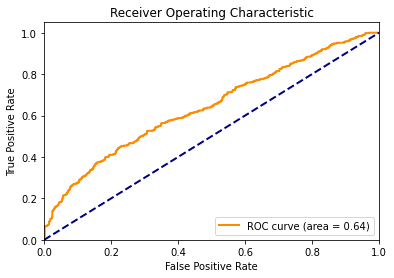

18/18 [==============================] - 1s 68ms/step - loss: 0.6529 - accuracy: 0.6054
Validation Loss: 0.6529285907745361
Validation Accuracy: 0.6053571701049805
Test Loss: 0.6508747441898589
Inference Time (seconds): 3.5341217517852783
Test Accuracy: 0.6058333333333333
Confusion Matrix:
 [[449 173]
 [300 278]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.72      0.65       622
           1       0.62      0.48      0.54       578

    accuracy                           0.61      1200
   macro avg       0.61      0.60      0.60      1200
weighted avg       0.61      0.61      0.60      1200

ROC AUC Score: 0.6411522713870871
Metrics saved successfully


In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [28]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 18s 263ms/step - loss: 0.6483 - accuracy: 0.6121 - val_loss: 0.6587 - val_accuracy: 0.6000
Epoch 2/150
70/70 [==============================] - 18s 263ms/step - loss: 0.6497 - accuracy: 0.6156 - val_loss: 0.6581 - val_accuracy: 0.5982
Epoch 3/150
70/70 [==============================] - 18s 263ms/step - loss: 0.6453 - accuracy: 0.6205 - val_loss: 0.6516 - val_accuracy: 0.5911
Epoch 4/150
70/70 [==============================] - 18s 262ms/step - loss: 0.6487 - accuracy: 0.6210 - val_loss: 0.6515 - val_accuracy: 0.5964
Epoch 5/150
70/70 [==============================] - 18s 262ms/step - loss: 0.6513 - accuracy: 0.6067 - val_loss: 0.6500 - val_accuracy: 0.6179
Epoch 6/150
70/70 [==============================] - 18s 263ms/step - loss: 0.6463 - accuracy: 0.6121 - val_loss: 0.6491 - val_accuracy: 0.6179
Epoch 7/150
70/70 [==============================] - 18s 261ms/step - loss: 0.6425 - accuracy: 0.6187 - val_loss: 0.6461 - val_accuracy:

38/38 [==============================] - 3s 70ms/step


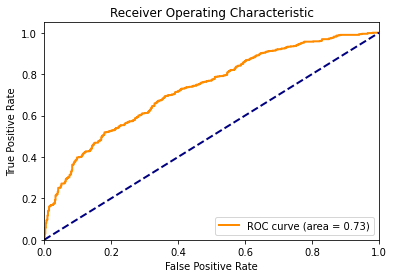

18/18 [==============================] - 1s 69ms/step - loss: 0.6103 - accuracy: 0.6625
Validation Loss: 0.6102703809738159
Validation Accuracy: 0.6625000238418579
Test Loss: 0.6039670953859786
Inference Time (seconds): 2.9428415298461914
Test Accuracy: 0.6608333333333334
Confusion Matrix:
 [[447 175]
 [232 346]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.72      0.69       622
           1       0.66      0.60      0.63       578

    accuracy                           0.66      1200
   macro avg       0.66      0.66      0.66      1200
weighted avg       0.66      0.66      0.66      1200

ROC AUC Score: 0.7303457982398558
Metrics saved successfully


In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 18s 263ms/step - loss: 0.5919 - accuracy: 0.6723 - val_loss: 0.6208 - val_accuracy: 0.6304
Epoch 2/200
70/70 [==============================] - 18s 262ms/step - loss: 0.5884 - accuracy: 0.6795 - val_loss: 0.6226 - val_accuracy: 0.6554
Epoch 3/200
70/70 [==============================] - 18s 261ms/step - loss: 0.5869 - accuracy: 0.6723 - val_loss: 0.6182 - val_accuracy: 0.6179
Epoch 4/200
70/70 [==============================] - 18s 257ms/step - loss: 0.5913 - accuracy: 0.6679 - val_loss: 0.6133 - val_accuracy: 0.6679
Epoch 5/200
70/70 [==============================] - 18s 256ms/step - loss: 0.5781 - accuracy: 0.6920 - val_loss: 0.5997 - val_accuracy: 0.6786
Epoch 6/200
70/70 [==============================] - 18s 256ms/step - loss: 0.5833 - accuracy: 0.6942 - val_loss: 0.6597 - val_accuracy: 0.6179
Epoch 7/200
70/70 [==============================] - 18s 256ms/step - loss: 0.5806 - accuracy: 0.6826 - val_loss: 0.6080 - val_accuracy:

38/38 [==============================] - 3s 69ms/step


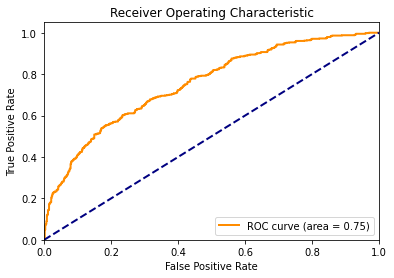

18/18 [==============================] - 1s 67ms/step - loss: 0.5997 - accuracy: 0.6786
Validation Loss: 0.599669337272644
Validation Accuracy: 0.6785714030265808
Test Loss: 0.5912892567513921
Inference Time (seconds): 2.8499460220336914
Test Accuracy: 0.6666666666666666
Confusion Matrix:
 [[398 224]
 [176 402]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.67       622
           1       0.64      0.70      0.67       578

    accuracy                           0.67      1200
   macro avg       0.67      0.67      0.67      1200
weighted avg       0.67      0.67      0.67      1200

ROC AUC Score: 0.7519651420242772
Metrics saved successfully


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GlobbalAveragePooling+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Conv2D+GlobalAveragePooling+Dropout+Dense

In [10]:
# Define custom CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),  # Global Average Pooling layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 110, 110, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 global_average_pooling2d_1  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [33]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 60s 846ms/step - loss: 0.6948 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 60s 850ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6930 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 60s 859ms/step - loss: 0.6928 - accuracy: 0.5223 - val_loss: 0.6920 - val_accuracy: 0.5304
Epoch 4/50
70/70 [==============================] - 61s 870ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6993 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 62s 884ms/step - loss: 0.6904 - accuracy: 0.5049 - val_loss: 0.6919 - val_accuracy: 0.5143
Epoch 6/50
70/70 [==============================] - 62s 893ms/step - loss: 0.6928 - accuracy: 0.5214 - val_loss: 0.6904 - val_accuracy: 0.5482
Epoch 7/50
70/70 [==============================] - 62s 882ms/step - loss: 0.6916 - accuracy: 0.5371 - val_loss: 0.6907 - val_accuracy: 0.5196

38/38 [==============================] - 7s 181ms/step


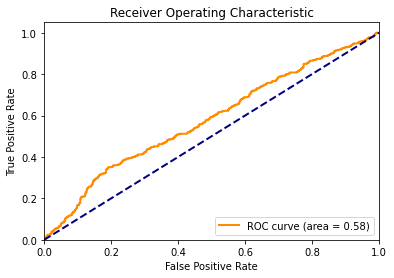

18/18 [==============================] - 3s 177ms/step - loss: 0.6904 - accuracy: 0.5482
Validation Loss: 0.690381646156311
Validation Accuracy: 0.5482142567634583
Test Loss: 0.6885027183120781
Inference Time (seconds): 7.134103536605835
Test Accuracy: 0.5791666666666667
Confusion Matrix:
 [[510 112]
 [393 185]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.82      0.67       622
           1       0.62      0.32      0.42       578

    accuracy                           0.58      1200
   macro avg       0.59      0.57      0.55      1200
weighted avg       0.59      0.58      0.55      1200

ROC AUC Score: 0.5794707328741976
Metrics saved successfully


In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [35]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 62s 886ms/step - loss: 0.6916 - accuracy: 0.5353 - val_loss: 0.6895 - val_accuracy: 0.5714
Epoch 2/100
70/70 [==============================] - 62s 893ms/step - loss: 0.6900 - accuracy: 0.5232 - val_loss: 0.6913 - val_accuracy: 0.5196
Epoch 3/100
70/70 [==============================] - 62s 893ms/step - loss: 0.6916 - accuracy: 0.5094 - val_loss: 0.6892 - val_accuracy: 0.5661
Epoch 4/100
70/70 [==============================] - 63s 899ms/step - loss: 0.6916 - accuracy: 0.5317 - val_loss: 0.6905 - val_accuracy: 0.5339
Epoch 5/100
70/70 [==============================] - 62s 880ms/step - loss: 0.6909 - accuracy: 0.5174 - val_loss: 0.6931 - val_accuracy: 0.4804
Epoch 6/100
70/70 [==============================] - 59s 849ms/step - loss: 0.6921 - accuracy: 0.5326 - val_loss: 0.6894 - val_accuracy: 0.5589
Epoch 7/100
70/70 [==============================] - 61s 867ms/step - loss: 0.6896 - accuracy: 0.5317 - val_loss: 0.6895 - val_accuracy:

38/38 [==============================] - 7s 181ms/step


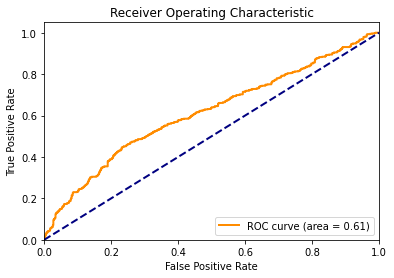

18/18 [==============================] - 3s 178ms/step - loss: 0.6713 - accuracy: 0.6089
Validation Loss: 0.6712566018104553
Validation Accuracy: 0.6089285612106323
Test Loss: 0.6701816154341077
Inference Time (seconds): 7.122774124145508
Test Accuracy: 0.61
Confusion Matrix:
 [[471 151]
 [317 261]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.76      0.67       622
           1       0.63      0.45      0.53       578

    accuracy                           0.61      1200
   macro avg       0.62      0.60      0.60      1200
weighted avg       0.61      0.61      0.60      1200

ROC AUC Score: 0.6139351238887839
Metrics saved successfully


In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 60s 845ms/step - loss: 0.6943 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 2/150
70/70 [==============================] - 61s 867ms/step - loss: 0.6940 - accuracy: 0.5022 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 3/150
70/70 [==============================] - 62s 878ms/step - loss: 0.6933 - accuracy: 0.5129 - val_loss: 0.6927 - val_accuracy: 0.5286
Epoch 4/150
70/70 [==============================] - 62s 891ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 5/150
70/70 [==============================] - 62s 889ms/step - loss: 0.6932 - accuracy: 0.5107 - val_loss: 0.6923 - val_accuracy: 0.5554
Epoch 6/150
70/70 [==============================] - 62s 882ms/step - loss: 0.6939 - accuracy: 0.5143 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 7/150
70/70 [==============================] - 62s 891ms/step - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6946 - val_accuracy:

38/38 [==============================] - 7s 180ms/step


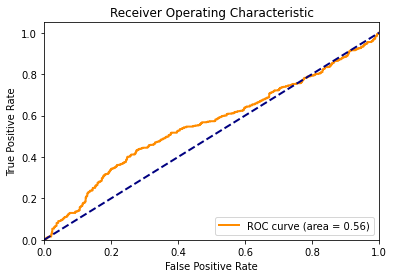

18/18 [==============================] - 3s 178ms/step - loss: 0.6923 - accuracy: 0.5554
Validation Loss: 0.692331850528717
Validation Accuracy: 0.5553571581840515
Test Loss: 0.6918476690471804
Inference Time (seconds): 7.104442119598389
Test Accuracy: 0.575
Confusion Matrix:
 [[502 120]
 [390 188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.81      0.66       622
           1       0.61      0.33      0.42       578

    accuracy                           0.57      1200
   macro avg       0.59      0.57      0.54      1200
weighted avg       0.59      0.57      0.55      1200

ROC AUC Score: 0.557449459829326
Metrics saved successfully


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 62s 887ms/step - loss: 0.6938 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 2/200
70/70 [==============================] - 61s 879ms/step - loss: 0.6937 - accuracy: 0.5067 - val_loss: 0.6938 - val_accuracy: 0.4875
Epoch 3/200
70/70 [==============================] - 61s 876ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 4/200
70/70 [==============================] - 62s 883ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 5/200
70/70 [==============================] - 63s 895ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 6/200
70/70 [==============================] - 62s 881ms/step - loss: 0.6928 - accuracy: 0.5170 - val_loss: 0.6922 - val_accuracy: 0.5464
Epoch 7/200
70/70 [==============================] - 61s 878ms/step - loss: 0.6927 - accuracy: 0.5196 - val_loss: 0.6933 - val_accuracy:

38/38 [==============================] - 7s 179ms/step


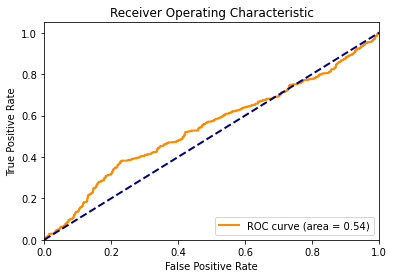

18/18 [==============================] - 3s 176ms/step - loss: 0.6897 - accuracy: 0.5571
Validation Loss: 0.6896847486495972
Validation Accuracy: 0.5571428537368774
Test Loss: 0.6875776740857192
Inference Time (seconds): 7.028772592544556
Test Accuracy: 0.5625
Confusion Matrix:
 [[445 177]
 [348 230]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.72      0.63       622
           1       0.57      0.40      0.47       578

    accuracy                           0.56      1200
   macro avg       0.56      0.56      0.55      1200
weighted avg       0.56      0.56      0.55      1200

ROC AUC Score: 0.5433207423313566
Metrics saved successfully


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+LSTM+Dense

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape,LSTM
from tensorflow.keras.models import Model


# Define the input shape
input_shape = (224, 224, 3)

# Define the CNN base model
input_layer = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)

# Define the LSTM layer
reshape = Reshape((1, -1))(flatten)
lstm = LSTM(128)(reshape)

# Define the dense layers for classification
dense1 = Dense(64, activation='relu')(lstm)
output_layer = Dense(1, activation='sigmoid')(dense1)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

NameError: name 'Conv2D' is not defined

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 55s 775ms/step - loss: 0.7096 - accuracy: 0.4906 - val_loss: 0.6953 - val_accuracy: 0.5125
Epoch 2/50
70/70 [==============================] - 54s 770ms/step - loss: 0.6950 - accuracy: 0.5174 - val_loss: 0.7102 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 54s 774ms/step - loss: 0.6980 - accuracy: 0.4924 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 4/50
70/70 [==============================] - 54s 770ms/step - loss: 0.6973 - accuracy: 0.5067 - val_loss: 0.6984 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 54s 769ms/step - loss: 0.6957 - accuracy: 0.4924 - val_loss: 0.6948 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 54s 769ms/step - loss: 0.6999 - accuracy: 0.4879 - val_loss: 0.7044 - val_accuracy: 0.4875
Epoch 7/50
70/70 [==============================] - 54s 768ms/step - loss: 0.6959 - accuracy: 0.4862 - val_loss: 0.7139 - val_accuracy: 0.4875

38/38 [==============================] - 3s 73ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


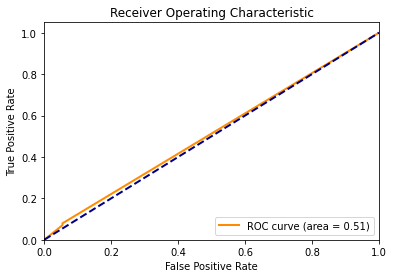

18/18 [==============================] - 1s 72ms/step - loss: 0.6930 - accuracy: 0.5125
Validation Loss: 0.6929616332054138
Validation Accuracy: 0.512499988079071
Test Loss: 0.6928559638779002
Inference Time (seconds): 3.426239013671875
Test Accuracy: 0.5183333333333333
Confusion Matrix:
 [[622   0]
 [578   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68       622
           1       0.00      0.00      0.00       578

    accuracy                           0.52      1200
   macro avg       0.26      0.50      0.34      1200
weighted avg       0.27      0.52      0.35      1200

ROC AUC Score: 0.5122247688559063
Metrics saved successfully


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 22s 304ms/step - loss: 0.7820 - accuracy: 0.5241 - val_loss: 0.7045 - val_accuracy: 0.5250
Epoch 2/100
70/70 [==============================] - 21s 307ms/step - loss: 0.6847 - accuracy: 0.5433 - val_loss: 0.6812 - val_accuracy: 0.5875
Epoch 3/100
70/70 [==============================] - 22s 312ms/step - loss: 0.6717 - accuracy: 0.5692 - val_loss: 0.6912 - val_accuracy: 0.5625
Epoch 4/100
70/70 [==============================] - 22s 314ms/step - loss: 0.6667 - accuracy: 0.5638 - val_loss: 0.6720 - val_accuracy: 0.6018
Epoch 5/100
70/70 [==============================] - 22s 313ms/step - loss: 0.6433 - accuracy: 0.5969 - val_loss: 0.6688 - val_accuracy: 0.5857
Epoch 6/100
70/70 [==============================] - 22s 312ms/step - loss: 0.6375 - accuracy: 0.6022 - val_loss: 0.6713 - val_accuracy: 0.5911
Epoch 7/100
70/70 [==============================] - 22s 313ms/step - loss: 0.6190 - accuracy: 0.6250 - val_loss: 0.6842 - val_accuracy:

38/38 [==============================] - 3s 73ms/step


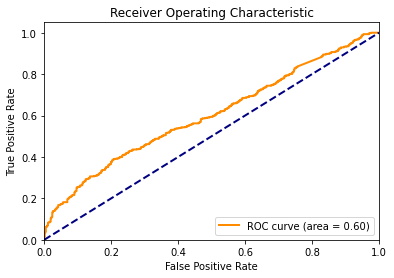

18/18 [==============================] - 1s 71ms/step - loss: 0.6567 - accuracy: 0.6018
Validation Loss: 0.6566851735115051
Validation Accuracy: 0.6017857193946838
Test Loss: 0.6916064245850276
Inference Time (seconds): 3.0786399841308594
Test Accuracy: 0.58
Confusion Matrix:
 [[424 198]
 [306 272]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.68      0.63       622
           1       0.58      0.47      0.52       578

    accuracy                           0.58      1200
   macro avg       0.58      0.58      0.57      1200
weighted avg       0.58      0.58      0.58      1200

ROC AUC Score: 0.6009871605158046
Metrics saved successfully


In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 22s 314ms/step - loss: 0.5833 - accuracy: 0.6464 - val_loss: 0.6620 - val_accuracy: 0.6232
Epoch 2/150
70/70 [==============================] - 22s 312ms/step - loss: 0.5536 - accuracy: 0.6812 - val_loss: 0.6924 - val_accuracy: 0.6161
Epoch 3/150
70/70 [==============================] - 22s 312ms/step - loss: 0.5246 - accuracy: 0.7076 - val_loss: 0.6893 - val_accuracy: 0.6625
Epoch 4/150
70/70 [==============================] - 22s 312ms/step - loss: 0.4914 - accuracy: 0.7455 - val_loss: 0.6736 - val_accuracy: 0.6839
Epoch 5/150
70/70 [==============================] - 22s 313ms/step - loss: 0.4145 - accuracy: 0.8031 - val_loss: 0.7134 - val_accuracy: 0.7393
Epoch 6/150
70/70 [==============================] - 22s 316ms/step - loss: 0.4003 - accuracy: 0.8058 - val_loss: 0.6874 - val_accuracy: 0.7375
Training Time: 132.002112865448 seconds


38/38 [==============================] - 3s 73ms/step


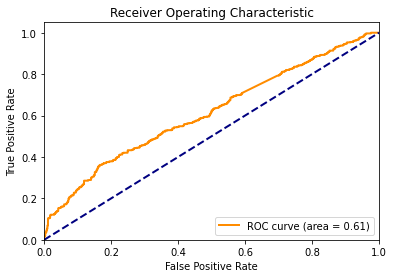

18/18 [==============================] - 1s 72ms/step - loss: 0.6620 - accuracy: 0.6232
Validation Loss: 0.6619884371757507
Validation Accuracy: 0.6232143044471741
Test Loss: 0.7131192892876348
Inference Time (seconds): 3.0900728702545166
Test Accuracy: 0.5925
Confusion Matrix:
 [[467 155]
 [334 244]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.75      0.66       622
           1       0.61      0.42      0.50       578

    accuracy                           0.59      1200
   macro avg       0.60      0.59      0.58      1200
weighted avg       0.60      0.59      0.58      1200

ROC AUC Score: 0.6125499282368517
Metrics saved successfully


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 22s 316ms/step - loss: 0.5570 - accuracy: 0.6705 - val_loss: 0.6965 - val_accuracy: 0.6232
Epoch 2/200
70/70 [==============================] - 22s 312ms/step - loss: 0.5453 - accuracy: 0.6786 - val_loss: 0.7173 - val_accuracy: 0.6107
Epoch 3/200
70/70 [==============================] - 22s 313ms/step - loss: 0.5175 - accuracy: 0.7013 - val_loss: 0.7010 - val_accuracy: 0.6304
Epoch 4/200
70/70 [==============================] - 22s 312ms/step - loss: 0.4978 - accuracy: 0.7241 - val_loss: 0.7170 - val_accuracy: 0.6375
Epoch 5/200
70/70 [==============================] - 22s 312ms/step - loss: 0.4985 - accuracy: 0.7420 - val_loss: 0.7492 - val_accuracy: 0.6571
Epoch 6/200
70/70 [==============================] - 22s 312ms/step - loss: 0.4496 - accuracy: 0.7679 - val_loss: 0.7168 - val_accuracy: 0.6893
Training Time: 131.79561638832092 seconds


38/38 [==============================] - 3s 72ms/step


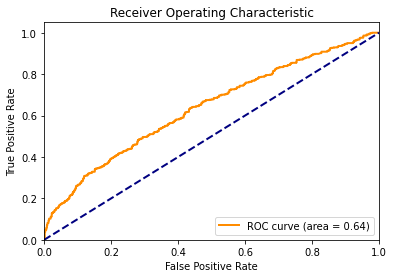

18/18 [==============================] - 1s 72ms/step - loss: 0.6965 - accuracy: 0.6232
Validation Loss: 0.6965067982673645
Validation Accuracy: 0.6232143044471741
Test Loss: 0.7086270080209914
Inference Time (seconds): 2.9911556243896484
Test Accuracy: 0.5991666666666666
Confusion Matrix:
 [[471 151]
 [330 248]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.76      0.66       622
           1       0.62      0.43      0.51       578

    accuracy                           0.60      1200
   macro avg       0.60      0.59      0.58      1200
weighted avg       0.60      0.60      0.59      1200

ROC AUC Score: 0.6362568008099779
Metrics saved successfully


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+GRU+Dense

In [15]:
from tensorflow.keras.layers import GRU

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer with 128 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Conv2D(256, (3, 3), activation='relu'),  # Convolutional layer with 256 filters and 3x3 kernel
    MaxPooling2D((2, 2)),  # Max pooling layer with 2x2 pool size
    Flatten(),  # Flatten layer to flatten the output of the convolutional layers
    Reshape((1, -1)),  # Reshape to 3D tensor for GRU
    GRU(128),  # GRU layer with 128 units
    Dense(1, activation='sigmoid')  # Dense layer for binary classification
])

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()                                                               

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

In [16]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 26s 359ms/step - loss: 0.7350 - accuracy: 0.4969 - val_loss: 0.6867 - val_accuracy: 0.5161
Epoch 2/50
70/70 [==============================] - 26s 377ms/step - loss: 0.6924 - accuracy: 0.5219 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 3/50
70/70 [==============================] - 26s 372ms/step - loss: 0.6930 - accuracy: 0.5112 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 4/50
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 26s 372ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 26s 372ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.4875
Training Time: 156.52616095542908 seconds


38/38 [==============================] - 3s 86ms/step


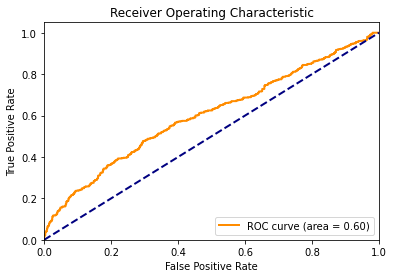

18/18 [==============================] - 2s 85ms/step - loss: 0.6867 - accuracy: 0.5161
Validation Loss: 0.6866776943206787
Validation Accuracy: 0.5160714387893677
Test Loss: 0.6863285776970084
Inference Time (seconds): 3.652141571044922
Test Accuracy: 0.5183333333333333
Confusion Matrix:
 [[131 491]
 [ 87 491]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.21      0.31       622
           1       0.50      0.85      0.63       578

    accuracy                           0.52      1200
   macro avg       0.55      0.53      0.47      1200
weighted avg       0.55      0.52      0.46      1200

ROC AUC Score: 0.6025948775576052
Metrics saved successfully


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 26s 374ms/step - loss: 0.6953 - accuracy: 0.5170 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 2/100
70/70 [==============================] - 26s 373ms/step - loss: 0.6932 - accuracy: 0.4951 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 3/100
70/70 [==============================] - 26s 371ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 4/100
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 5/100
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 26s 371ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Training Time: 156.91392040252686 seconds


38/38 [==============================] - 3s 86ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


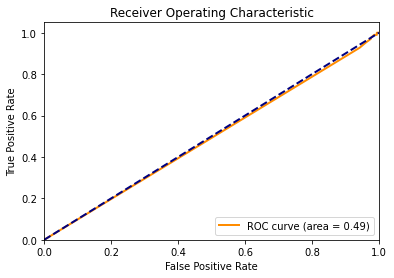

18/18 [==============================] - 2s 83ms/step - loss: 0.6931 - accuracy: 0.5125
Validation Loss: 0.6931129097938538
Validation Accuracy: 0.512499988079071
Test Loss: 0.6930966174547704
Inference Time (seconds): 4.157625198364258
Test Accuracy: 0.5183333333333333
Confusion Matrix:
 [[622   0]
 [578   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68       622
           1       0.00      0.00      0.00       578

    accuracy                           0.52      1200
   macro avg       0.26      0.50      0.34      1200
weighted avg       0.27      0.52      0.35      1200

ROC AUC Score: 0.49276249179452375
Metrics saved successfully


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 26s 374ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 2/150
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 3/150
70/70 [==============================] - 26s 372ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 4/150
70/70 [==============================] - 26s 371ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 5/150
70/70 [==============================] - 26s 372ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 6/150
70/70 [==============================] - 26s 371ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Training Time: 156.90376543998718 seconds


38/38 [==============================] - 3s 86ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


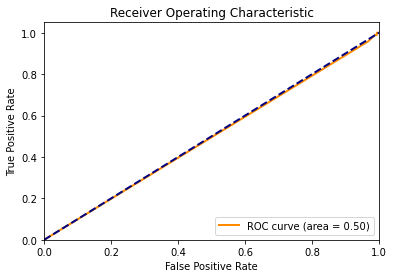

18/18 [==============================] - 2s 84ms/step - loss: 0.6933 - accuracy: 0.4875
Validation Loss: 0.6932578682899475
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6933056176466394
Inference Time (seconds): 3.513946771621704
Test Accuracy: 0.4816666666666667
Confusion Matrix:
 [[  0 622]
 [  0 578]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

ROC AUC Score: 0.49539241647103327
Metrics saved successfully


In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 26s 374ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 2/200
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 3/200
70/70 [==============================] - 26s 372ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 4/200
70/70 [==============================] - 26s 371ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 5/200
70/70 [==============================] - 26s 372ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6938 - val_accuracy: 0.4875
Epoch 6/200
70/70 [==============================] - 26s 371ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6938 - val_accuracy: 0.4875
Training Time: 156.42329120635986 seconds


38/38 [==============================] - 3s 85ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


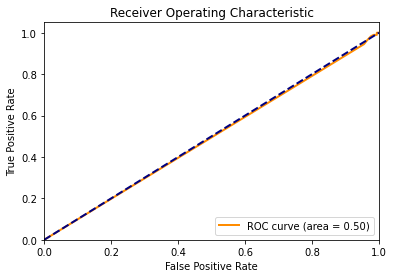

18/18 [==============================] - 2s 83ms/step - loss: 0.6934 - accuracy: 0.4875
Validation Loss: 0.6933794617652893
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6934729772864633
Inference Time (seconds): 3.4919726848602295
Test Accuracy: 0.4816666666666667
Confusion Matrix:
 [[  0 622]
 [  0 578]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

ROC AUC Score: 0.4951170462510709
Metrics saved successfully


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Attention Mechanism+Dense

In [24]:
from tensorflow.keras.layers import Multiply

#Define the custom CNN architecture with attention mechanism
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
attention_probs = Dense(np.prod(x.shape[1:]), activation='softmax', name='attention_probs')(x)
attention_mul = Multiply()([x, attention_probs])
x = Dense(1, activation='sigmoid')(attention_mul)

# Create the model
model = Model(inputs=input_layer, outputs=x)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 222, 222, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 32)         0         ['conv2d_10[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_10[0][0]']

In [25]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 28s 374ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 26s 372ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 26s 372ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 4/50
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 26s 371ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 26s 371ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Training Time: 158.29256343841553 seconds


38/38 [==============================] - 3s 74ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


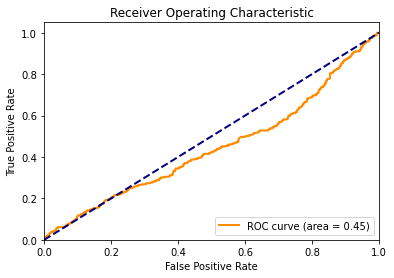

18/18 [==============================] - 1s 73ms/step - loss: 0.6933 - accuracy: 0.4875
Validation Loss: 0.6932687163352966
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6933320818523424
Inference Time (seconds): 3.1076629161834717
Test Accuracy: 0.4816666666666667
Confusion Matrix:
 [[  0 622]
 [  0 578]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

ROC AUC Score: 0.4460399537155509
Metrics saved successfully


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 26s 374ms/step - loss: 0.6942 - accuracy: 0.5129 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 2/100
70/70 [==============================] - 26s 377ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 3/100
70/70 [==============================] - 26s 373ms/step - loss: 0.6922 - accuracy: 0.5129 - val_loss: 0.6859 - val_accuracy: 0.4875
Epoch 4/100
70/70 [==============================] - 26s 372ms/step - loss: 0.6891 - accuracy: 0.5129 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 5/100
70/70 [==============================] - 26s 372ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 26s 372ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 7/100
70/70 [==============================] - 26s 373ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy:

38/38 [==============================] - 3s 74ms/step


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


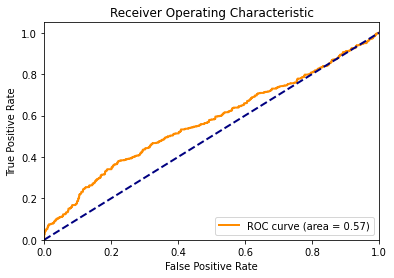

18/18 [==============================] - 1s 74ms/step - loss: 0.6859 - accuracy: 0.4875
Validation Loss: 0.6858992576599121
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6861935902521565
Inference Time (seconds): 3.0689375400543213
Test Accuracy: 0.4816666666666667
Confusion Matrix:
 [[  0 622]
 [  0 578]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

ROC AUC Score: 0.570775709565082
Metrics saved successfully


In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 26s 375ms/step - loss: 0.6882 - accuracy: 0.5196 - val_loss: 0.6835 - val_accuracy: 0.5857
Epoch 2/150
70/70 [==============================] - 26s 373ms/step - loss: 0.6830 - accuracy: 0.5455 - val_loss: 0.6871 - val_accuracy: 0.5232
Epoch 3/150
70/70 [==============================] - 26s 372ms/step - loss: 0.6860 - accuracy: 0.5518 - val_loss: 0.6831 - val_accuracy: 0.5732
Epoch 4/150
70/70 [==============================] - 26s 372ms/step - loss: 0.6818 - accuracy: 0.5728 - val_loss: 0.6779 - val_accuracy: 0.6000
Epoch 5/150
70/70 [==============================] - 26s 373ms/step - loss: 0.6838 - accuracy: 0.5277 - val_loss: 0.6803 - val_accuracy: 0.5750
Epoch 6/150
70/70 [==============================] - 26s 372ms/step - loss: 0.6826 - accuracy: 0.5259 - val_loss: 0.6907 - val_accuracy: 0.5161
Epoch 7/150
70/70 [==============================] - 26s 372ms/step - loss: 0.6794 - accuracy: 0.5335 - val_loss: 0.6793 - val_accuracy:

38/38 [==============================] - 3s 75ms/step


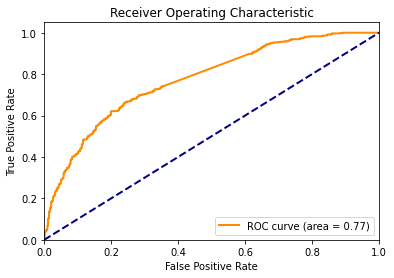

18/18 [==============================] - 1s 72ms/step - loss: 0.5399 - accuracy: 0.7179
Validation Loss: 0.5399057269096375
Validation Accuracy: 0.7178571224212646
Test Loss: 0.5791994812131107
Inference Time (seconds): 3.081087589263916
Test Accuracy: 0.7008333333333333
Confusion Matrix:
 [[434 188]
 [171 407]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       622
           1       0.68      0.70      0.69       578

    accuracy                           0.70      1200
   macro avg       0.70      0.70      0.70      1200
weighted avg       0.70      0.70      0.70      1200

ROC AUC Score: 0.773364745936203
Metrics saved successfully


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 26s 374ms/step - loss: 0.5429 - accuracy: 0.7259 - val_loss: 0.5619 - val_accuracy: 0.6821
Epoch 2/200
70/70 [==============================] - 26s 372ms/step - loss: 0.5462 - accuracy: 0.7116 - val_loss: 0.5380 - val_accuracy: 0.7125
Epoch 3/200
70/70 [==============================] - 26s 371ms/step - loss: 0.5274 - accuracy: 0.7357 - val_loss: 0.5585 - val_accuracy: 0.6839
Epoch 4/200
70/70 [==============================] - 26s 372ms/step - loss: 0.5249 - accuracy: 0.7286 - val_loss: 0.5712 - val_accuracy: 0.7268
Epoch 5/200
70/70 [==============================] - 26s 373ms/step - loss: 0.5167 - accuracy: 0.7344 - val_loss: 0.5670 - val_accuracy: 0.6696
Epoch 6/200
70/70 [==============================] - 26s 371ms/step - loss: 0.5254 - accuracy: 0.7156 - val_loss: 0.5494 - val_accuracy: 0.7071
Epoch 7/200
70/70 [==============================] - 26s 371ms/step - loss: 0.5076 - accuracy: 0.7348 - val_loss: 0.5361 - val_accuracy:

38/38 [==============================] - 3s 73ms/step


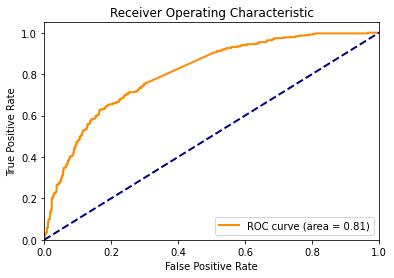

18/18 [==============================] - 1s 72ms/step - loss: 0.5044 - accuracy: 0.7500
Validation Loss: 0.5044185519218445
Validation Accuracy: 0.75
Test Loss: 0.5760366913075444
Inference Time (seconds): 3.0122828483581543
Test Accuracy: 0.7216666666666667
Confusion Matrix:
 [[447 175]
 [159 419]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       622
           1       0.71      0.72      0.72       578

    accuracy                           0.72      1200
   macro avg       0.72      0.72      0.72      1200
weighted avg       0.72      0.72      0.72      1200

ROC AUC Score: 0.8066761979995327
Metrics saved successfully


In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Attention Mechanism+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# CNN+Capsule Network+Dense

In [33]:
from tensorflow.keras.layers import Layer

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j
# Define your custom CNN architecture
input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Reshape((-1, 128))(x)  # Reshape to 3D tensor for Capsule Network
capsule = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
capsule = Flatten()(capsule)  # Flatten the output
output = Dense(1, activation='sigmoid')(capsule)  # Use a single output unit for binary classification

# Create the full model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 128)       7385

In [34]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=50, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 22s 308ms/step - loss: 0.6967 - accuracy: 0.5112 - val_loss: 0.6970 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 21s 306ms/step - loss: 0.6943 - accuracy: 0.5080 - val_loss: 0.6962 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 21s 305ms/step - loss: 0.6928 - accuracy: 0.5192 - val_loss: 0.6896 - val_accuracy: 0.5179
Epoch 4/50
70/70 [==============================] - 21s 306ms/step - loss: 0.6952 - accuracy: 0.4991 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 5/50
70/70 [==============================] - 21s 306ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 21s 306ms/step - loss: 0.6930 - accuracy: 0.5147 - val_loss: 0.6928 - val_accuracy: 0.5125
Epoch 7/50
70/70 [==============================] - 21s 306ms/step - loss: 0.6942 - accuracy: 0.5040 - val_loss: 0.6944 - val_accuracy: 0.4875

38/38 [==============================] - 3s 75ms/step


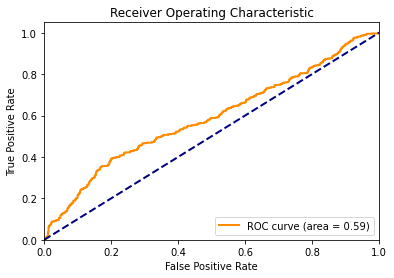

18/18 [==============================] - 1s 73ms/step - loss: 0.6896 - accuracy: 0.5179
Validation Loss: 0.6895748972892761
Validation Accuracy: 0.5178571343421936
Test Loss: 0.6894628044047012
Inference Time (seconds): 3.1597325801849365
Test Accuracy: 0.52
Confusion Matrix:
 [[619   3]
 [573   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      1.00      0.68       622
           1       0.62      0.01      0.02       578

    accuracy                           0.52      1200
   macro avg       0.57      0.50      0.35      1200
weighted avg       0.57      0.52      0.36      1200

ROC AUC Score: 0.5877777345097297
Metrics saved successfully


In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val,y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [36]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=100, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 22s 320ms/step - loss: 0.6881 - accuracy: 0.5420 - val_loss: 0.6859 - val_accuracy: 0.5339
Epoch 2/100
70/70 [==============================] - 22s 315ms/step - loss: 0.6774 - accuracy: 0.5670 - val_loss: 0.6698 - val_accuracy: 0.5714
Epoch 3/100
70/70 [==============================] - 22s 314ms/step - loss: 0.6731 - accuracy: 0.5705 - val_loss: 0.6575 - val_accuracy: 0.6143
Epoch 4/100
70/70 [==============================] - 22s 314ms/step - loss: 0.6483 - accuracy: 0.6223 - val_loss: 0.6185 - val_accuracy: 0.6554
Epoch 5/100
70/70 [==============================] - 22s 315ms/step - loss: 0.6267 - accuracy: 0.6580 - val_loss: 0.6262 - val_accuracy: 0.6393
Epoch 6/100
70/70 [==============================] - 22s 315ms/step - loss: 0.6029 - accuracy: 0.6835 - val_loss: 0.6455 - val_accuracy: 0.6018
Epoch 7/100
70/70 [==============================] - 22s 314ms/step - loss: 0.5813 - accuracy: 0.7071 - val_loss: 0.6182 - val_accuracy:

38/38 [==============================] - 3s 74ms/step


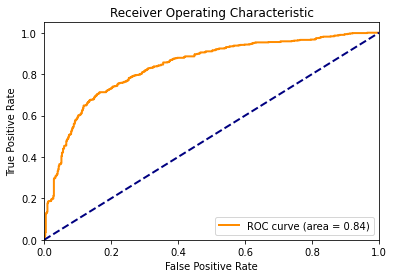

18/18 [==============================] - 1s 72ms/step - loss: 0.4337 - accuracy: 0.8018
Validation Loss: 0.43370383977890015
Validation Accuracy: 0.8017857074737549
Test Loss: 0.5267247357825998
Inference Time (seconds): 3.066789150238037
Test Accuracy: 0.7633333333333333
Confusion Matrix:
 [[465 157]
 [127 451]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77       622
           1       0.74      0.78      0.76       578

    accuracy                           0.76      1200
   macro avg       0.76      0.76      0.76      1200
weighted avg       0.76      0.76      0.76      1200

ROC AUC Score: 0.8380989997663526
Metrics saved successfully


In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [38]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=150, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 22s 317ms/step - loss: 0.3005 - accuracy: 0.8719 - val_loss: 0.4760 - val_accuracy: 0.7982
Epoch 2/150
70/70 [==============================] - 22s 314ms/step - loss: 0.2782 - accuracy: 0.8875 - val_loss: 0.4441 - val_accuracy: 0.8125
Epoch 3/150
70/70 [==============================] - 22s 315ms/step - loss: 0.2861 - accuracy: 0.8808 - val_loss: 0.4837 - val_accuracy: 0.8000
Epoch 4/150
70/70 [==============================] - 22s 314ms/step - loss: 0.2844 - accuracy: 0.8754 - val_loss: 0.4670 - val_accuracy: 0.8143
Epoch 5/150
70/70 [==============================] - 22s 313ms/step - loss: 0.2316 - accuracy: 0.9022 - val_loss: 0.4677 - val_accuracy: 0.8161
Epoch 6/150
70/70 [==============================] - 22s 315ms/step - loss: 0.2154 - accuracy: 0.9174 - val_loss: 0.5021 - val_accuracy: 0.8143
Epoch 7/150
70/70 [==============================] - 22s 316ms/step - loss: 0.2077 - accuracy: 0.9165 - val_loss: 0.4933 - val_accuracy:

38/38 [==============================] - 3s 74ms/step


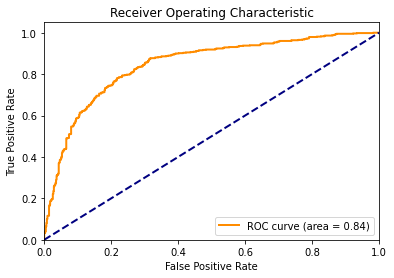

18/18 [==============================] - 1s 72ms/step - loss: 0.4441 - accuracy: 0.8125
Validation Loss: 0.4441105127334595
Validation Accuracy: 0.8125
Test Loss: 0.5290035359438333
Inference Time (seconds): 3.0408077239990234
Test Accuracy: 0.775
Confusion Matrix:
 [[499 123]
 [147 431]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.79       622
           1       0.78      0.75      0.76       578

    accuracy                           0.78      1200
   macro avg       0.78      0.77      0.77      1200
weighted avg       0.78      0.78      0.77      1200

ROC AUC Score: 0.8448497424314911
Metrics saved successfully


In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [40]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

import time

# Record start time
start_train_time = time.time()

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, batch_size=32, epochs=200, 
                    validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

# Record end time
end_train_time = time.time()

# Calculate training time
training_time = end_train_time - start_train_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 22s 318ms/step - loss: 0.2596 - accuracy: 0.8951 - val_loss: 0.4554 - val_accuracy: 0.7982
Epoch 2/200
70/70 [==============================] - 22s 317ms/step - loss: 0.2654 - accuracy: 0.8893 - val_loss: 0.4591 - val_accuracy: 0.8054
Epoch 3/200
70/70 [==============================] - 22s 313ms/step - loss: 0.2283 - accuracy: 0.9085 - val_loss: 0.4652 - val_accuracy: 0.8232
Epoch 4/200
70/70 [==============================] - 22s 315ms/step - loss: 0.2162 - accuracy: 0.9134 - val_loss: 0.4564 - val_accuracy: 0.7982
Epoch 5/200
70/70 [==============================] - 22s 316ms/step - loss: 0.2137 - accuracy: 0.9121 - val_loss: 0.4959 - val_accuracy: 0.8179
Epoch 6/200
70/70 [==============================] - 22s 314ms/step - loss: 0.1939 - accuracy: 0.9219 - val_loss: 0.5024 - val_accuracy: 0.8232
Training Time: 132.81822085380554 seconds


38/38 [==============================] - 3s 74ms/step


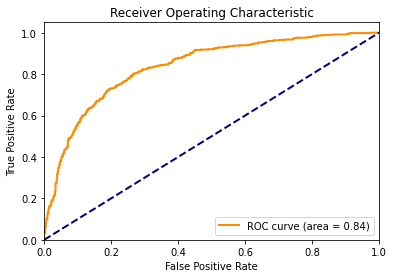

18/18 [==============================] - 1s 72ms/step - loss: 0.4554 - accuracy: 0.7982
Validation Loss: 0.4554018974304199
Validation Accuracy: 0.7982142567634583
Test Loss: 0.5598656128060291
Inference Time (seconds): 3.0589599609375
Test Accuracy: 0.7633333333333333
Confusion Matrix:
 [[489 133]
 [151 427]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       622
           1       0.76      0.74      0.75       578

    accuracy                           0.76      1200
   macro avg       0.76      0.76      0.76      1200
weighted avg       0.76      0.76      0.76      1200

ROC AUC Score: 0.836620623282413
Metrics saved successfully


In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical values for test data
y_test_encoded = label_encoder.fit_transform(y_test)

# Record start time for inference
start_inference_time = time.time()

# Evaluate on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Record end time for inference
end_inference_time = time.time()

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_binary)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_binary)

# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate test loss
test_loss = log_loss(y_test_encoded, y_pred)

# Calculate validation loss and accuracy
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Measure time complexity for inference
inference_time = end_inference_time - start_inference_time

# Print additional metrics
print("Test Loss:", test_loss)
print("Inference Time (seconds):", inference_time)

# Print metrics
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)
print("ROC AUC Score:", roc_auc)

kappa = cohen_kappa_score(y_test, y_pred_binary)
mcc = matthews_corrcoef(y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
existing_metrics_df=pd.read_csv('CNN_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['CNN+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('CNN_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")